In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import shutil
import os
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

In [2]:
sys.path.append("../fastai/")
from fastai.conv_learner import *

### train a detection/segmentation model for images with ships

**idea : rather than fine tuning imagenet for detection/segmentation fine tune with the fine tuned model for ship classifier** 

- train_seg_lbs : images in train_all folder with segmentation
- test_seg_lbs : images in test_all folder with segmentation

In [3]:
path = Path("../DATA/airbus-ship/")
files = list(path.iterdir())

In [4]:
files

[PosixPath('../DATA/airbus-ship/segmentations'),
 PosixPath('../DATA/airbus-ship/classification'),
 PosixPath('../DATA/airbus-ship/test_ship_segmentations.csv'),
 PosixPath('../DATA/airbus-ship/test_all'),
 PosixPath('../DATA/airbus-ship/sample_submission.csv'),
 PosixPath('../DATA/airbus-ship/tmp'),
 PosixPath('../DATA/airbus-ship/models'),
 PosixPath('../DATA/airbus-ship/train_all'),
 PosixPath('../DATA/airbus-ship/train_ship_segmentations.csv')]

### visualize segmentation data

In [5]:
train_seg_lbs = pd.read_csv(path/"segmentations/train_seg_lbs.csv")
test_seg_lbs = pd.read_csv(path/"segmentations/test_seg_lbs.csv")

In [11]:
print(f"# of train segmentation images: {train_seg_lbs.ImageId.nunique()}")
print(f"# of test segmentation images: {test_seg_lbs.ImageId.nunique()}")

# of train segmentation images: 38300
# of test segmentation images: 4256


In [13]:
print(f"# of train segmentation labels/ships: {len(train_seg_lbs.ImageId)}")
print(f"# of test segmentation labels/ships: {len(test_seg_lbs)}")

# of train segmentation labels/ships: 73605
# of test segmentation labels/ships: 8118


In [14]:
from rle import rle_decode, rle_encode
from seg_plots import show_imgmasks

In [90]:
# get random image labels
ship_ids = train_seg_lbs.ImageId.unique()
ship_id = np.random.choice(ship_ids)
rles = train_seg_lbs[train_seg_lbs.ImageId == ship_id]['EncodedPixels'].values
print(f"# of ships in image : {len(rles)}")

# read image and decode mask
img = open_image(str(path/"train_all"/ship_id))
masks = sum([rle_decode(rle, img.shape[:2]) for rle in rles])

# of ships in image : 14


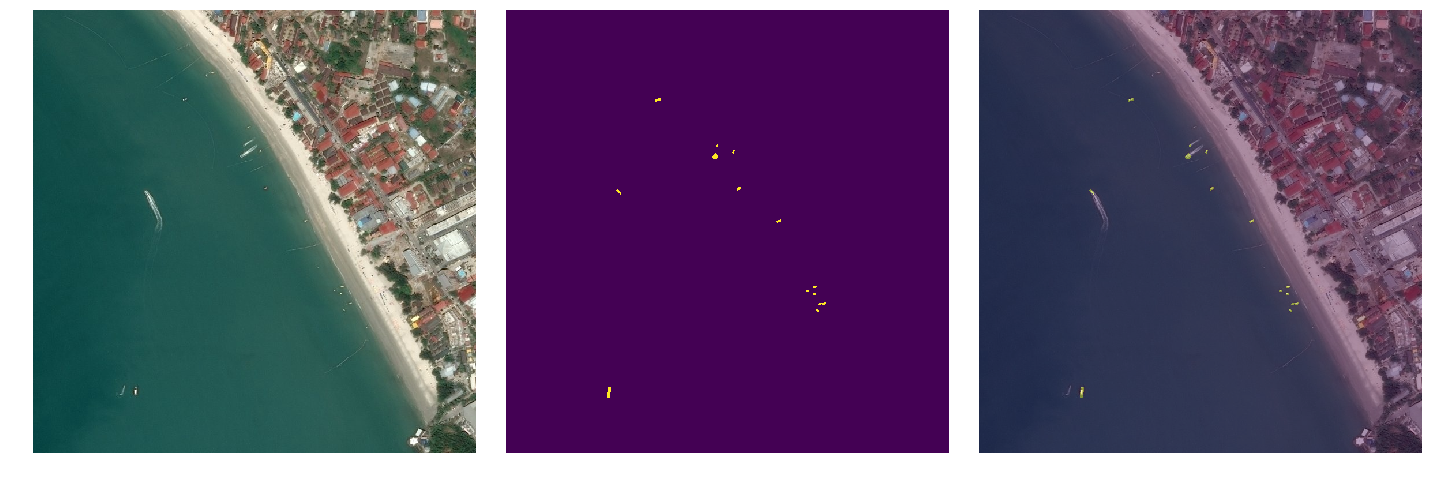

In [91]:
show_imgmasks(img, masks, (20, 20))

### save all masks 

Having rle_decode inside get_y is very expensive

In [98]:
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

In [92]:
trn_unique_img_ids = train_seg_lbs.ImageId.unique()
test_unique_img_ids = test_seg_lbs.ImageId.unique()

In [93]:
os.makedirs(path/'segmentations/train_masks', exist_ok=True)
os.makedirs(path/'segmentations/test_masks', exist_ok=True)

In [96]:
def save_train_mask(img_id):
    rles = train_seg_lbs[train_seg_lbs.ImageId == img_id]['EncodedPixels'].values
    masks = sum([rle_decode(rle, (768, 768)) for rle in rles])
    plt.imsave(str(path/'segmentations/train_masks'/img_id), masks)

In [97]:
def save_test_mask(img_id):
    rles = test_seg_lbs[test_seg_lbs.ImageId == img_id]['EncodedPixels'].values
    masks = sum([rle_decode(rle, (768, 768)) for rle in rles])
    plt.imsave(str(path/'segmentations/test_masks'/img_id), masks)

In [99]:
# save train masks
with ProcessPoolExecutor() as executor:
    executor.map(save_train_mask, trn_unique_img_ids)

In [101]:
# save test masks
with ProcessPoolExecutor() as executor:
    executor.map(save_test_mask, test_unique_img_ids)

### model 2 - dynamic unet segmentation 

In [102]:
from fastai.models.unet import *
from fastai.dataset import *
from fastai.core import *

In [103]:
train_seg_lbs = pd.read_csv(path/"segmentations/train_seg_lbs.csv")
test_seg_lbs = pd.read_csv(path/"segmentations/test_seg_lbs.csv")

In [105]:
unique_img_ids = train_seg_lbs.ImageId.unique()
trn_fnames, val_fnames = train_test_split(unique_img_ids, test_size=0.1, random_state=42)

In [106]:
TRN_X = [f"train_all/{fname}" for fname in trn_fnames]
TRN_Y = [f"segmentations/train_masks/{fname}" for fname in trn_fnames]

VAL_X = [f"train_all/{fname}" for fname in val_fnames]
VAL_Y = [f"segmentations/train_masks/{fname}" for fname in val_fnames]

In [107]:
sz = 256

class FilesEncodedDataset(BaseDataset):
    def __init__(self, fnames, fnames2, transform, path):
        self.fnames = fnames
        self.fnames2 = fnames2
        self.path = path
        super().__init__(transform)
    
    def get_sz(self): return self.transform.sz
    def get_x(self, i): return open_image(os.path.join(self.path, self.fnames[i]))
    def get_y(self, i): 
        mask = cv2.imread(os.path.join(self.path, self.fnames2[i]), cv2.IMREAD_GRAYSCALE)
        mask = (mask - 30)/185
        return cv2.resize(mask, (sz, sz)).astype('float32')
        
    def get_n(self): return len(self.fnames)
    def get_c(self): return 0

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

    def denorm(self,arr):
        """Reverse the normalization done to a batch of images.

        Arguments:
            arr: of shape/size (N,3,sz,sz)
        """
        if type(arr) is not np.ndarray: arr = to_np(arr)
        if len(arr.shape)==3: arr = arr[None]
        return self.transform.denorm(np.rollaxis(arr,1,4))

In [108]:
f = resnet18
tfms = tfms_from_model(f, sz, crop_type=CropType.NO, tfm_y=None) # imagenet stats

In [109]:
dataset = ImageData.get_ds(FilesEncodedDataset, (TRN_X, TRN_Y),
                           (VAL_X, VAL_Y),
                           tfms=tfms, path = path)

In [110]:
md = ImageData(path, dataset, bs=16, num_workers=16, classes=None)

In [111]:
print(f"n train: {len(md.trn_ds)}, n val: {len(md.val_ds)}")

n train: 34470, n val: 3830


### model

In [112]:
# load defined model# load  
def get_encoder(f, cut):
    base_model = (cut_model(f(True), cut))
    return nn.Sequential(*base_model)

def get_model(sz=128):
    """gets dynamic unet model"""
    # choose encoder
    f = resnet18
    cut, cut_lr = model_meta[f]
    cut, cut_lr

    # define encoder
    encoder = get_encoder(f, cut)

    # init model
    m = DynamicUnet(encoder, n_classes=1) # binary: ship - not ship

    # init upsample on cpu
    inp = torch.ones(1, 3, sz, sz)
    out = m(V(inp).cpu())

    # put model to gpu if desired# put mo 
    m = m.cuda(0)
    return m

In [113]:
class BCELoss2D(nn.Module):
    def __init__(self):
        super(BCELoss2D, self).__init__()
        
    def forward(self, logits, targets):
        logits = logits.squeeze(1)
        return F.binary_cross_entropy_with_logits(logits, targets)

In [114]:
class UpsampleModel():
    def __init__(self, model, cut_lr, name='upsample'):
        self.model,self.name, self.cut_lr = model, name, cut_lr

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.encoder), [self.cut_lr]))
        return lgs + [children(self.model)[1:]]

In [50]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 72%|███████▏  | 1550/2155 [05:51<02:17,  4.40it/s, loss=0.034]  

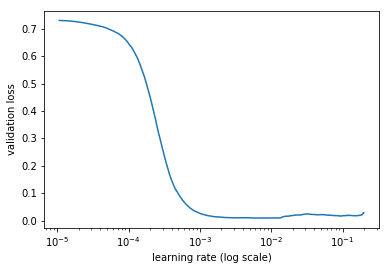

In [51]:
learn.sched.plot()

### evaluation metric

- we need indv. GT and predicted labels

In [121]:
from skimage.measure import label
from eval_metric import sigmoid, get_gt_masks, get_gt_masks, create_iou_matrix, f2_IOU

In [126]:
def single_image_score(labels, gt_rles, gt):
    """return avg thresholded f2 score for single image"""
    if len(np.unique(labels)) == 1:
        if gt is None: 
            """original image has no instance"""
            return 1
        else:
            """no prediction is made tp = 0"""
            return 0
    else:
        pred_mask_arrays = get_pred_masks(labels)
        gt_mask_arrays = get_gt_masks(gt_rles)
        IOU = create_iou_matrix(pred_mask_arrays, gt_mask_arrays)
        return f2_IOU(IOU)

### test metric

ref: https://www.kaggle.com/stkbailey/step-by-step-explanation-of-scoring-metric

In [127]:
shift = 0 # shift to keep track of file index 
n_valids = len(md.val_ds) # total # of validation samples
fnames = md.val_ds.fnames # validation filenames
df = train_seg_lbs

def fastai_metric(preds, targs):
    global shift
    global df
    global fnames
    global n_valids
    mask_thresh = 0.5 
    n_x = len(preds)

    scores = [] 
    preds = (sigmoid(to_np(preds).squeeze(1)) > mask_thresh).astype('uint8')
    gts = to_np(targs)
    
    for i, (gt_i, pred_i) in enumerate(zip(gts, preds)):
        fname = fnames[i+shift]
        gt_rles = df[df.ImageId == fname.split("/")[-1]]['EncodedPixels'].values
        labels = label(pred_i)
        scores.append(single_image_score(labels, gt_rles, gt_i))

    shift += n_x
    if shift == n_valids: shift = 0
    return np.mean(scores)

### train with eval metric

In [128]:
cut, cut_lr = model_meta[f]

In [ ]:
model = get_model(sz=256)
models = UpsampleModel(model, cut_lr)

In [ ]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit = BCELoss2D()
learn.metrics = [fastai_metric]

In [ ]:
learn.fit(1e-3, 10, cycle_len=1)

### train earlier layers

In [47]:
learn.unfreeze()

In [ ]:
lr = 1e-3
lrs = [lr/100, lr/10, lr]
learn.fit(lrs, 5, cycle_len=1)